In [1946]:
import pandas as pd
import numpy as np

In [1947]:
# reading the data
cdp_summary = pd.read_stata("../../data/CDP Cleaning/cleaned outputs/cdp_summary.dta").replace("", pd.NA)

Total Number Of Frim Years and total number of unique firms.

In [1948]:
# number of rows and columns
cdp_summary.shape

(34588, 10)

In [1949]:
# do a mapping of id and isin
id_isin = cdp_summary[["id", "isin"]].drop_duplicates()

There are some firms who have multiple isins, I will create a mappnig between firms and isins to make sure that any Isin can be used to match a firm.

In [1950]:
id_isin['id'].value_counts().head(10)

id
22499    5
20712    4
21459    4
8054     4
14820    4
11853    4
7616     4
15981    3
9411     3
59242    3
Name: count, dtype: int64

In [1951]:
cdp_summary.groupby("id")['isin'].nunique().value_counts()

isin
0    6895
1    4098
2     268
3      23
4       4
5       1
Name: count, dtype: int64

Roughly 30% of the firm-years have missin isins.

In [1952]:
cdp_summary['isin'].isna().mean()

0.2907366716780386

Identifying the problem: some firms have multiple ISINS because they change isin over time.

What if I can map ISIN from the beginning through the mapping table? To check.

In [1953]:
# Step 1: Group by 'id' and calculate unique 'isin' counts per 'id'
unique_isin_counts = cdp_summary.groupby("id")['isin'].nunique()

# Step 2: Filter IDs that have exactly 4 unique 'isin' values
ids_with_4_isins = unique_isin_counts[unique_isin_counts == 4].index

# Step 3: Use these IDs to locate rows in the original DataFrame
rows_with_4_isins = cdp_summary[cdp_summary['id'].isin(ids_with_4_isins)]


rows_with_4_isins.head(20)

,id,reporting_boundary,year,companyname,country,industry14,isin,ticker,industry46,cdpdate
6852,7616,<NA>,2010.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,NaT
6853,7616,<NA>,2011.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,NaT
6854,7616,<NA>,2012.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,NaT
6855,7616,<NA>,2013.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,2013-06-28
6856,7616,<NA>,2014.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,2014-06-10
6857,7616,<NA>,2015.0,Google Inc.,USA,<NA>,US38259P7069,GOOG US,software services,2015-06-30
6858,7616,<NA>,2016.0,"Alphabet, Inc.",USA,Services,US02079K1079,GOOG US,software services,2016-07-25
6859,7616,<NA>,2017.0,"Alphabet, Inc.",USA,Services,US02079K1079,GOOG US,software services,2017-07-15
6860,7616,operational control,2018.0,"Alphabet, Inc.",USA,Services,US02079K1079,"GOOG US, GOOGL US",software services,2018-09-13
6861,7616,operational control,2019.0,"Alphabet, Inc.",USA,Services,US02079K1079,"GOOG US, GOOGL US",software services,2019-08-29


In [1954]:
# Assuming 'date_column' is the name of your date or timestamp column
# Step 1: Identify the most recent 'isin' for each 'id'
# Sort the DataFrame by 'id' and 'date_column' in descending order
cdp_summary_sorted = cdp_summary.sort_values(by=['id', 'year'], ascending=[True, False])

# Drop duplicates based on 'id', keeping the first (most recent) occurrence
recent_isin_per_id = cdp_summary_sorted.drop_duplicates(subset='id', keep='first')[['id', 'isin']]

# Step 2: Update all rows to use the most recent 'isin' for each 'id'
# Merge the most recent 'isin' back onto the original DataFrame, based on 'id'
cdp_summary_updated = cdp_summary.merge(recent_isin_per_id, on='id', suffixes=('', '_recent'))

# Replace old 'isin' values with the most recent ones
cdp_summary_updated['isin'] = cdp_summary_updated['isin_recent']

# Drop the temporary 'isin_recent' column
cdp_summary_updated.drop(columns=['isin_recent'], inplace=True)

# cdp_summary_updated now has all rows updated to the most recent 'isin' for each 'id'
cdp_summary = cdp_summary_updated

In [1955]:
cdp_summary.groupby("id")['isin'].nunique().value_counts()

isin
0    6959
1    4330
Name: count, dtype: int64

In [1956]:
# number of unique fimrs
len(cdp_summary['id'].unique())

11289

In [1957]:
# number of firm years without an isin
cdp_summary['isin'].isna().sum()

9785

In [1958]:
# number of firm years without an isin 
(cdp_summary.groupby('id')['isin'].sum() == 0).sum()

6959

In [1959]:
# dropping the firm years without an isin
cdp_summary = cdp_summary[cdp_summary['isin'].notna()]

In [1960]:
cdp_summary.shape

(24803, 10)

In [1961]:
# creating an id_year_isin_mapping
id_year_isin_mapping = cdp_summary[['id', 'year', 'isin']]

In [1962]:
# checking for duplicates
id_year_isin_mapping

,id,year,isin
0,44,2011.0,GB00B1YW4409
1,44,2012.0,GB00B1YW4409
2,44,2013.0,GB00B1YW4409
3,44,2014.0,GB00B1YW4409
4,44,2016.0,GB00B1YW4409
...,...,...,...
34550,895420,2022.0,KYG2R55E1030
34552,895480,2022.0,US6031581068
34564,895556,2022.0,US53960E1064
34572,895582,2022.0,MYL5211OO007


In [1963]:
id_year_isin_mapping.groupby(['id']).isin.nunique().value_counts()

isin
1    4330
Name: count, dtype: int64

In [1964]:
# drop rows where isin == "NA"
id_year_isin_mapping = id_year_isin_mapping[id_year_isin_mapping['isin'] != "NA"]

# drop the value 0 and ""
id_year_isin_mapping = id_year_isin_mapping[id_year_isin_mapping['isin'] != 0]
id_year_isin_mapping = id_year_isin_mapping[id_year_isin_mapping['isin'] != ""]

In [1965]:
len(id_year_isin_mapping['isin'].unique())

4302

In [1966]:
id_year_isin_mapping['isin'].unique()

array(['GB00B1YW4409', 'ES0111845014', 'US0009571003', ...,
       'US53960E1064', 'MYL5211OO007', 'US04206A1016'], dtype=object)

In [1967]:
# preparing the data for wrds query
unique_isin_series = id_year_isin_mapping['isin'].unique()

# Open a text file in write mode
with open('unique_isin_values.txt', 'w') as file:
    for isin in unique_isin_series:
        file.write(f"{isin}\n")  # Write each ISIN followed by a newline

In [1968]:
# read financial.csv
financial = pd.read_csv("../../data/raw/financial_v2.csv")

In [1969]:
financial.columns

Index(['code', 'year_', 'freq', 'ITEM7011', 'ITEM7210', 'ITEM7220', 'ITEM7230',
       'ITEM7240', 'ITEM7250', 'ITEM8301', 'ITEM8601', 'ITEM8621', 'ITEM8626',
       'ITEM8630', 'ITEM8636', 'ITEM6001', 'ITEM6008', 'ITEM6011'],
      dtype='object')

In [1970]:
colnames = ['code', 'year', 'freq', 'employees', 'mkt cap', 'common equity',
       'tot assets', 'revenue', 'net income', 'roe', 'eps 1yr gr', 'assets 1y gr',
        'employees 1y gr', 'employees 5y gr', 'net income 1y gr', 'name', 'isin', 'sector']

In [1971]:
financial.columns = colnames

In [1972]:
financial['isin'].unique().shape

(4215,)

There are 186 firms without wrds data

- there also seem to be 99 isins that I dropped but that still are in refinitiv, it might be the case that those isins where changed to a later one, or that the new one is not registered yet
- i would drop the 186 firms that don't have the most recent isin

In [1973]:
# get using id_isins, all the ids that correspond to the unique_isin_series

len(id_isin.loc[id_isin['isin'].isin(unique_isin_series)]['id'].unique())

4316

In [1974]:
len(id_isin.loc[id_isin['isin'].isin(financial['isin'])]['id'].unique())

4149

In [1975]:
4316 - 4149

167

In [1976]:
# Merge financial DataFrame with id_isin DataFrame based on 'isin' column
# Assuming 'isin' is the common column in both DataFrames
# This adds the 'id' column from id_isin to financial based on matching 'isin' values
financial = financial.merge(id_isin[['isin', 'id']], on='isin', how='left')

In [1977]:
financial.sort_values(by=['id', 'year'], inplace=True)

In [1978]:
financial['sector'].unique()

array([4350., 8580., 3410., 4395., 8240., 5510., 2580., 6130., 4090.,
       8220., 3110., 4310., 2840., 2810., 5290., 4370., 3430.,   nan,
       8210., 4030., 4050., 2510., 7910., 8510., 7080., 8592., 7950.,
       4970., 7010., 4010., 2893., 4080., 4060., 5240., 8260., 5292.,
       4610., 1920., 6140., 2530., 5291., 2870., 5220., 8591., 4992.,
       6430., 4320., 5210., 6110., 3740., 4380., 7620., 8250., 6770.,
       2210., 6440., 8230., 3420., 4391., 4392., 5820., 8270., 6750.,
       5230., 8540., 5280., 4660., 6710., 8530., 7970., 2540., 1910.,
       5570., 4394., 3730., 7091., 4690., 5530., 1320., 5870., 4070.,
       2230., 4940., 3440., 6120., 5880., 4630., 2880., 2550., 4620.,
       4930., 2220., 4910., 1610., 5890., 7920., 3750., 6780., 7060.,
       7070., 2520., 7930., 4040., 7320., 5850., 4640., 8550., 1350.,
       5830., 8280., 4680., 4390., 3710., 2892., 7940., 4950., 7040.,
       8590., 4020., 6760., 7020., 4920., 4650., 7030., 8570., 7960.,
       8520., 6420.,

In [1979]:
financial.isna().mean()

code                0.000000
year                0.000000
freq                0.000000
employees           0.266797
mkt cap             0.089789
common equity       0.175666
tot assets          0.170654
revenue             0.169636
net income          0.169717
roe                 0.195971
eps 1yr gr          0.255497
assets 1y gr        0.184574
employees 1y gr     0.288218
employees 5y gr     0.346886
net income 1y gr    0.340452
name                0.000000
isin                0.000000
sector              0.124709
id                  0.000000
dtype: float64

In [1980]:
financial_selected = financial[['id', 'year', 'sector', 'employees', 'mkt cap', 'tot assets', 'revenue', 'net income', 'roe', 'eps 1yr gr', 'assets 1y gr', 'employees 1y gr', 'net income 1y gr']]

Note that I have to align financial to summary, so since summary 2022 = financial 2021, I will add 1 to financial year to align

In [1981]:
financial_selected = financial_selected.copy()
financial_selected['year'] = financial_selected['year'] + 1

In [1982]:
# inner join with cdp_summary so if there is no financial data at all we remove the firm year
cdp_summary = cdp_summary.merge(financial_selected, on=['id', 'year'], how='inner')

In [1983]:
cdp_summary.dropna(subset=['tot assets'], inplace=True)

In [1984]:
# firm years after merging with financial information
cdp_summary.shape

(22474, 21)

In [1985]:
cdp_summary.isna().mean()

id                    0.000000
reporting_boundary    0.517932
year                  0.000000
companyname           0.000000
country               0.000044
industry14            0.129527
isin                  0.000000
ticker                0.010234
industry46            0.215627
cdpdate               0.122586
sector                0.000000
employees             0.082050
mkt cap               0.008632
tot assets            0.000000
revenue               0.000178
net income            0.000133
roe                   0.018644
eps 1yr gr            0.192178
assets 1y gr          0.008721
employees 1y gr       0.097802
net income 1y gr      0.190086
dtype: float64

In [1986]:
# write unique cdp summary isins to a txt file
unique_isin_series = cdp_summary['isin'].unique()

# Open a text file in write mode
with open('unique_isin_values_cdp_summary.txt', 'w') as file:
    for isin in unique_isin_series:
        file.write(f"{isin}\n")  # Write each ISIN followed by a newline

In [1987]:
cdp_summary.loc[cdp_summary['country'] == "USA"]

,id,reporting_boundary,year,companyname,country,industry14,isin,ticker,industry46,cdpdate,...,employees,mkt cap,tot assets,revenue,net income,roe,eps 1yr gr,assets 1y gr,employees 1y gr,net income 1y gr
23,58,operational control,2021.0,ABM INDUSTRIES INC,USA,Services,US0009571003,ABM US,<NA>,2021-07-28,...,114000.0,2.525750e+09,3.776900e+09,5.987600e+09,3.000000e+05,0.01972,-99.76580,2.28294,-18.57143,-99.76471
24,58,operational control,2022.0,ABM INDUSTRIES INC,USA,Services,US0009571003,ABM US,<NA>,2022-07-29,...,124000.0,2.749305e+09,4.436200e+09,6.228600e+09,1.263000e+08,8.12349,41544.61883,17.45611,8.77193,42000.00000
25,64,<NA>,2011.0,Abbott Laboratories,USA,"Biotech, health care & pharma",US0028241000,ABT US,pharmaceuticals biotechnology life sciences,NaT,...,90000.0,7.411600e+10,5.881024e+10,3.516700e+10,4.626000e+09,20.44999,-19.51220,13.88856,23.28767,-19.48656
26,64,<NA>,2012.0,Abbott Laboratories,USA,"Biotech, health care & pharma",US0028241000,ABT US,pharmaceuticals biotechnology life sciences,NaT,...,91000.0,8.830240e+10,5.831397e+10,3.885100e+10,4.728449e+09,20.07125,1.68350,-0.84385,1.11111,2.21083
27,64,<NA>,2013.0,Abbott Laboratories,USA,"Biotech, health care & pharma",US0028241000,ABT US,pharmaceuticals biotechnology life sciences,2013-05-30,...,91000.0,1.032717e+11,6.420664e+10,3.987391e+10,5.962920e+09,23.31051,23.84106,10.10507,0.00000,26.10731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26591,893875,operational control,2022.0,Sunnova Energy International,USA,Power generation,US86745K1043,NOVA UN,<NA>,2022-08-02,...,738.0,3.165754e+09,5.504234e+09,2.417520e+08,-1.381280e+08,-12.90177,NaN,53.42462,85.42714,NaN
26594,894946,operational control,2022.0,Primoris Services Corporation,USA,Infrastructure,US74164F1030,PRIM UW,<NA>,2022-07-11,...,1925.0,1.275606e+09,2.542020e+09,3.497632e+09,1.156110e+08,13.56292,0.75238,29.18928,9.25085,10.13299
26595,895062,operational control,2022.0,"Asana, Inc.",USA,Services,US04342Y1047,ASAN UN,<NA>,2022-07-28,...,1666.0,1.403765e+10,7.070350e+08,3.784370e+08,-2.883420e+08,-301.84820,NaN,-3.29413,54.25926,NaN
26599,895480,operational control,2022.0,Minerals Technologies Inc.,USA,Materials,US6031581068,MTX UN,<NA>,2022-07-27,...,3961.0,2.426912e+09,3.351200e+09,1.858300e+09,1.644000e+08,10.95963,47.99440,5.24795,11.07684,46.26335


In [1988]:
gics_int = pd.read_csv("../../data/raw/gics_int.csv")

In [1989]:
gics_int

,gvkey,fyear,datadate,isin,gind
0,1166,2010.0,2010-12-31,NL0000334118,453010.0
1,1166,2011.0,2011-12-31,NL0000334118,453010.0
2,1166,2012.0,2012-12-31,NL0000334118,453010.0
3,1166,2013.0,2013-12-31,NL0000334118,453010.0
4,1166,2014.0,2014-12-31,NL0000334118,453010.0
...,...,...,...,...,...
38004,352810,2018.0,2018-12-31,BRAUREACNOR9,551050.0
38005,352810,2019.0,2019-12-31,BRAUREACNOR9,551050.0
38006,352810,2020.0,2020-12-31,BRAUREACNOR9,551050.0
38007,352810,2021.0,2021-12-31,BRAUREACNOR9,551050.0


In [1990]:
gics['isin'].unique().shape

(3980,)

In [1991]:
cdp_summary['isin'].unique().shape

(4066,)

Using WRDS to map isin to gvkey, and then using gvkey to map to isin, I can create a mapping table that will allow me to map any isin to a firm.

In [1992]:
gvkey_isin = pd.read_csv("../../data/raw/gvkeys_mapping.csv")

In [1993]:
gvkey_isin['gvkey'].unique().shape

(4088,)

In [1994]:
# read gics_usa
gics_usa = pd.read_csv("../../data/raw/gics_usa.csv")

In [1995]:
gics_usa = gics_usa[['gvkey', 'fyear', 'datadate','gind']]

In [1996]:
gics_usa.gvkey.unique().shape

(1249,)

In [1997]:
# now add the isin to gics_usa
gics_usa = gics_usa.merge(gvkey_isin, on='gvkey')

In [1998]:
gics_usa = gics_usa[['gvkey', 'fyear',	'datadate',	'isin',	'gind']]

In [1999]:
# now concatatenate gics_usa with gics_int
gics = pd.concat([gics_usa, gics_int])


In [2000]:
# drop duplicate rows
gics.drop_duplicates(inplace=True)

In [2001]:
gics.columns = ['gvkey', 'year', 'datadate', 'isin', 'gind']
gics

,gvkey,year,datadate,isin,gind
0,1045,2010.0,2010-12-31,US02376R1023,203020.0
1,1045,2011.0,2011-12-31,US02376R1023,203020.0
2,1045,2012.0,2012-12-31,US02376R1023,203020.0
3,1045,2013.0,2013-12-31,US02376R1023,203020.0
4,1045,2014.0,2014-12-31,US02376R1023,203020.0
...,...,...,...,...,...
38004,352810,2018.0,2018-12-31,BRAUREACNOR9,551050.0
38005,352810,2019.0,2019-12-31,BRAUREACNOR9,551050.0
38006,352810,2020.0,2020-12-31,BRAUREACNOR9,551050.0
38007,352810,2021.0,2021-12-31,BRAUREACNOR9,551050.0


In [2002]:
# ok now add gind to cdp_summary based on isin and year
cdp_summary = cdp_summary.merge(gics, on=['isin', 'year'], how='left')

In [2003]:
# dropping no idustry classification rows
cdp_summary.dropna(subset=['gind'], inplace=True)

In [2004]:
cdp_summary.head()

,id,reporting_boundary,year,companyname,country,industry14,isin,ticker,industry46,cdpdate,...,revenue,net income,roe,eps 1yr gr,assets 1y gr,employees 1y gr,net income 1y gr,gvkey,datadate,gind
0,44,<NA>,2011.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,NaT,...,866463950.0,2.336873e+08,6.24746,NaN,20.38540,-24.50142,NaN,210835.0,2012-03-31,402030.0
1,44,<NA>,2012.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,NaT,...,623395840.0,2.980762e+08,5.78988,13.95349,-2.96546,-11.32075,20.77922,210835.0,2013-03-31,402030.0
2,44,<NA>,2013.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,2013-06-18,...,475960320.0,-1.254804e+09,-26.16979,NaN,-20.12502,0.42553,NaN,210835.0,2014-03-31,402030.0
3,44,<NA>,2014.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,2014-06-26,...,582068080.0,2.781161e+08,6.58155,NaN,-6.32609,-24.15254,NaN,210835.0,2015-03-31,402030.0
4,44,<NA>,2016.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,2016-06-27,...,909628720.0,1.037036e+09,19.67951,34.82156,10.95550,0.74349,35.39652,210835.0,2017-03-31,402030.0


# now let's start filtering the data!

In [2005]:
# number of firm-years after merging with financial data, gics, and dropping columns with missing values
cdp_summary.shape

(21848, 24)

In [2006]:
cdp_summary.isna().mean()

id                    0.000000
reporting_boundary    0.515974
year                  0.000000
companyname           0.000000
country               0.000046
industry14            0.124176
isin                  0.000000
ticker                0.010436
industry46            0.215580
cdpdate               0.122940
sector                0.000000
employees             0.080969
mkt cap               0.006683
tot assets            0.000000
revenue               0.000183
net income            0.000092
roe                   0.018629
eps 1yr gr            0.189262
assets 1y gr          0.008605
employees 1y gr       0.096347
net income 1y gr      0.187294
gvkey                 0.000000
datadate              0.000000
gind                  0.000000
dtype: float64

In [2007]:
# how many firms have total assets less than 1M
(cdp_summary['tot assets'] < 1e7).sum()

0

In [2008]:
cdp_summary.loc[cdp_summary['tot assets'] == cdp_summary['tot assets'].max()]['tot assets']

7546    3.743567e+12
Name: tot assets, dtype: float64

In [2009]:
# dropping cdpdate, sector, gvkey
cdp_summary.drop(columns=['cdpdate', 'sector', 'gvkey','eps 1yr gr','net income 1y gr','industry14', 'industry46','isin',
                          'ticker', 'isin', 'reporting_boundary'], inplace=True)

In [2010]:
cdp_summary.isna().mean()

id                 0.000000
year               0.000000
companyname        0.000000
country            0.000046
employees          0.080969
mkt cap            0.006683
tot assets         0.000000
revenue            0.000183
net income         0.000092
roe                0.018629
assets 1y gr       0.008605
employees 1y gr    0.096347
datadate           0.000000
gind               0.000000
dtype: float64

In [2011]:
cdp_summary.dropna(inplace=True)

In [2012]:
cdp_summary['gind'] = ((cdp_summary['gind'] - cdp_summary['gind'] % 100) / 100).astype(int)

In [2013]:
cdp_summary

,id,year,companyname,country,employees,mkt cap,tot assets,revenue,net income,roe,assets 1y gr,employees 1y gr,datadate,gind
0,44,2011.0,3i Group,United Kingdom,530.0,4.200627e+09,9.006066e+09,8.664640e+08,2.336873e+08,6.24746,20.38540,-24.50142,2012-03-31,4020
1,44,2012.0,3i Group,United Kingdom,470.0,4.555430e+09,9.229143e+09,6.233958e+08,2.980762e+08,5.78988,-2.96546,-11.32075,2013-03-31,4020
2,44,2013.0,3i Group,United Kingdom,472.0,3.217196e+09,7.371776e+09,4.759603e+08,-1.254804e+09,-26.16979,-20.12502,0.42553,2014-03-31,4020
3,44,2014.0,3i Group,United Kingdom,358.0,4.665116e+09,6.548646e+09,5.820681e+08,2.781161e+08,6.58155,-6.32609,-24.15254,2015-03-31,4020
4,44,2016.0,3i Group,United Kingdom,271.0,6.949796e+09,7.277030e+09,9.096287e+08,1.037036e+09,19.67951,10.95550,0.74349,2017-03-31,4020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22525,895173,2022.0,Flex LNG Ltd.,Bermuda,8.0,1.190050e+09,2.572921e+09,3.381685e+08,1.597116e+08,18.61960,12.89307,-11.11111,2022-12-31,1010
22526,895420,2022.0,China Everbright Greentech Limited,Hong Kong,3800.0,7.764964e+08,5.189436e+09,1.083497e+09,1.424291e+08,8.44866,14.93437,35.71429,2022-12-31,5510
22527,895480,2022.0,Minerals Technologies Inc.,USA,3961.0,2.426912e+09,3.351200e+09,1.858300e+09,1.644000e+08,10.95963,5.24795,11.07684,2022-12-31,1510
22528,895582,2022.0,Sunway Berhad,Malaysia,10889.0,2.018544e+09,6.009856e+09,8.923026e+08,6.395736e+08,27.20387,19.03571,7.69459,2022-12-31,2010


# Creating Continents

In [2014]:
import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return None

# Example
country_name = 'China'
print(country_to_continent(country_name))

Asia


In [2015]:
# apply the function to the country column
cdp_summary = cdp_summary.copy()
cdp_summary['continent'] = cdp_summary['country'].apply(country_to_continent)
cdp_summary.dropna(subset=['continent'], inplace=True)

In [2016]:
# mapping from gics codes to industry names
lst =list(cdp_summary['gind'].unique())

2540, 4040 do not exist -> dropping them

In [2017]:
lst.sort()

print(lst)

[1010, 1510, 2010, 2020, 2030, 2510, 2520, 2530, 2540, 2550, 3010, 3020, 3030, 3510, 3520, 4010, 4020, 4030, 4040, 4510, 4520, 4530, 5010, 5020, 5510, 6010, 6020]


In [2018]:
cdp_summary = cdp_summary.loc[(cdp_summary['gind'] != 4040) & (cdp_summary['gind'] != 2540)]

In [2019]:
cdp_summary.drop(columns=['datadate'], inplace=True)

# This is great for EDA - let's add in the emissions change data!!

In [2020]:
ghg_change = pd.read_csv("../../data/processed/cdp_ghg_change_processed.csv")

In [2021]:
# merging with ghg_change based on id and year
cdp_summary = cdp_summary.merge(ghg_change, on=['id', 'year'], how='left')

In [2022]:
cdp_summary.dropna(subset=['ghg_change_real'], inplace=True)

In [2023]:
cdp_summary.columns

Index(['id', 'year', 'companyname', 'country', 'employees', 'mkt cap',
       'tot assets', 'revenue', 'net income', 'roe', 'assets 1y gr',
       'employees 1y gr', 'gind', 'continent', 'ghg_change_total',
       'ghg_change_real', 'ghg_change_structure', 'ghg_change_measure',
       'ghg_change_othergroup', 'ghg_change_nonzero_count',
       'ghg_change_output', 'ghg_change_output_missing',
       'ghg_change_real_next'],
      dtype='object')

In [2024]:
cdp_summary.drop(columns=['ghg_change_output_missing'], inplace=True)

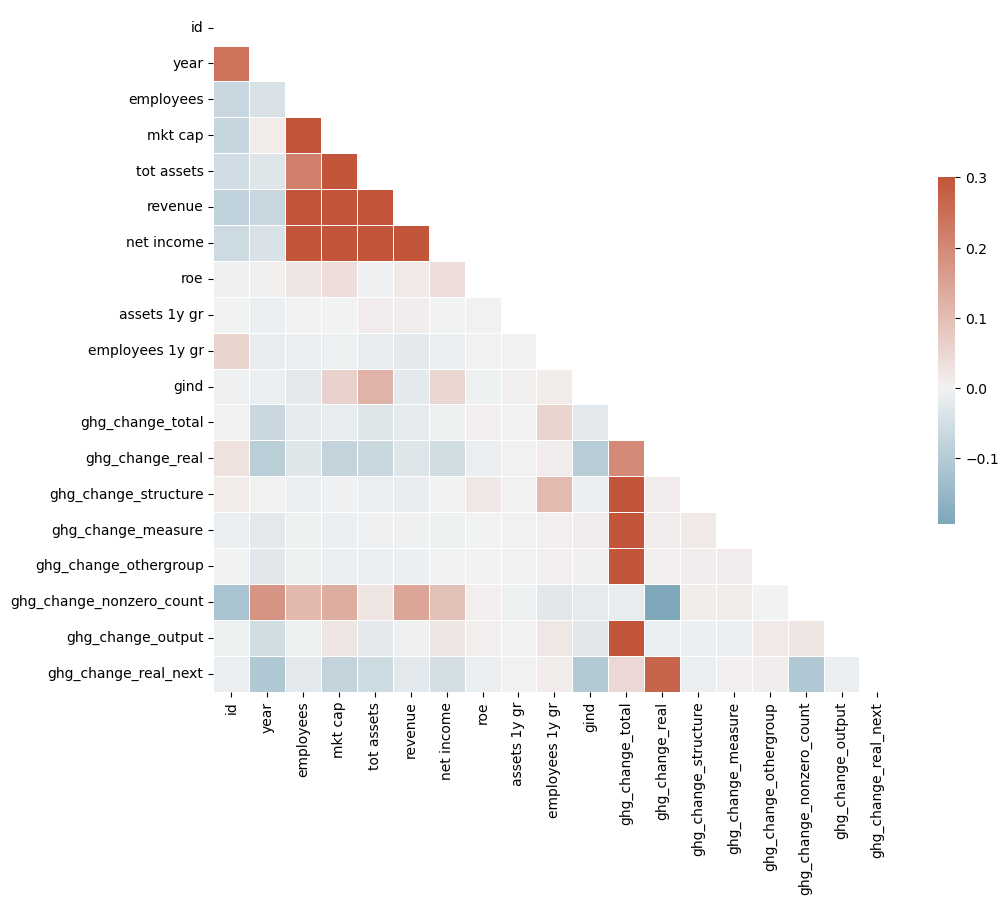

In [2025]:
# sns heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = cdp_summary.drop(columns=['companyname', 'country', 'continent']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [2026]:
# recenter the year to 0 by subtracting 2011
cdp_summary['year'] = cdp_summary['year'] - 2011

In [2027]:
cdp_summary

,id,year,companyname,country,employees,mkt cap,tot assets,revenue,net income,roe,...,gind,continent,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output,ghg_change_real_next
0,44,0.0,3i Group,United Kingdom,530.0,4.200627e+09,9.006066e+09,8.664640e+08,2.336873e+08,6.24746,...,4020,Europe,-11.00,-11.00,0.0,0.0,0.00,1.0,0.0,0.0
1,44,1.0,3i Group,United Kingdom,470.0,4.555430e+09,9.229143e+09,6.233958e+08,2.980762e+08,5.78988,...,4020,Europe,-25.00,0.00,0.0,0.0,-25.00,1.0,0.0,-1.0
2,44,2.0,3i Group,United Kingdom,472.0,3.217196e+09,7.371776e+09,4.759603e+08,-1.254804e+09,-26.16979,...,4020,Europe,-19.00,-1.00,0.0,-1.0,-17.00,3.0,0.0,0.0
3,44,3.0,3i Group,United Kingdom,358.0,4.665116e+09,6.548646e+09,5.820681e+08,2.781161e+08,6.58155,...,4020,Europe,-29.00,0.00,0.0,0.0,-29.00,1.0,0.0,0.0
4,44,5.0,3i Group,United Kingdom,271.0,6.949796e+09,7.277030e+09,9.096287e+08,1.037036e+09,19.67951,...,4020,Europe,-4.00,0.00,0.0,0.0,-4.00,1.0,0.0,-39.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19150,895173,11.0,Flex LNG Ltd.,Bermuda,8.0,1.190050e+09,2.572921e+09,3.381685e+08,1.597116e+08,18.61960,...,1010,North America,59.86,49.86,0.0,0.0,10.00,2.0,0.0,NaN
19151,895420,11.0,China Everbright Greentech Limited,Hong Kong,3800.0,7.764964e+08,5.189436e+09,1.083497e+09,1.424291e+08,8.44866,...,5510,Asia,12.55,0.00,0.0,0.0,12.55,1.0,0.0,NaN
19152,895480,11.0,Minerals Technologies Inc.,USA,3961.0,2.426912e+09,3.351200e+09,1.858300e+09,1.644000e+08,10.95963,...,1510,North America,0.00,0.00,0.0,0.0,0.00,0.0,0.0,NaN
19153,895582,11.0,Sunway Berhad,Malaysia,10889.0,2.018544e+09,6.009856e+09,8.923026e+08,6.395736e+08,27.20387,...,2010,Asia,0.97,0.97,0.0,0.0,0.00,2.0,0.0,NaN


In [2028]:
cdp_summary.drop_duplicates(subset=['id', 'year'], keep='first', inplace=True)

In [2029]:
cdp_summary

,id,year,companyname,country,employees,mkt cap,tot assets,revenue,net income,roe,...,gind,continent,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output,ghg_change_real_next
0,44,0.0,3i Group,United Kingdom,530.0,4.200627e+09,9.006066e+09,8.664640e+08,2.336873e+08,6.24746,...,4020,Europe,-11.00,-11.00,0.0,0.0,0.00,1.0,0.0,0.0
1,44,1.0,3i Group,United Kingdom,470.0,4.555430e+09,9.229143e+09,6.233958e+08,2.980762e+08,5.78988,...,4020,Europe,-25.00,0.00,0.0,0.0,-25.00,1.0,0.0,-1.0
2,44,2.0,3i Group,United Kingdom,472.0,3.217196e+09,7.371776e+09,4.759603e+08,-1.254804e+09,-26.16979,...,4020,Europe,-19.00,-1.00,0.0,-1.0,-17.00,3.0,0.0,0.0
3,44,3.0,3i Group,United Kingdom,358.0,4.665116e+09,6.548646e+09,5.820681e+08,2.781161e+08,6.58155,...,4020,Europe,-29.00,0.00,0.0,0.0,-29.00,1.0,0.0,0.0
4,44,5.0,3i Group,United Kingdom,271.0,6.949796e+09,7.277030e+09,9.096287e+08,1.037036e+09,19.67951,...,4020,Europe,-4.00,0.00,0.0,0.0,-4.00,1.0,0.0,-39.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19150,895173,11.0,Flex LNG Ltd.,Bermuda,8.0,1.190050e+09,2.572921e+09,3.381685e+08,1.597116e+08,18.61960,...,1010,North America,59.86,49.86,0.0,0.0,10.00,2.0,0.0,NaN
19151,895420,11.0,China Everbright Greentech Limited,Hong Kong,3800.0,7.764964e+08,5.189436e+09,1.083497e+09,1.424291e+08,8.44866,...,5510,Asia,12.55,0.00,0.0,0.0,12.55,1.0,0.0,NaN
19152,895480,11.0,Minerals Technologies Inc.,USA,3961.0,2.426912e+09,3.351200e+09,1.858300e+09,1.644000e+08,10.95963,...,1510,North America,0.00,0.00,0.0,0.0,0.00,0.0,0.0,NaN
19153,895582,11.0,Sunway Berhad,Malaysia,10889.0,2.018544e+09,6.009856e+09,8.923026e+08,6.395736e+08,27.20387,...,2010,Asia,0.97,0.97,0.0,0.0,0.00,2.0,0.0,NaN


In [2030]:
# convert the gind to string based on the mapping from gics codes to Industry Group
gind_mapping = {1010: 'Energy', 1510: 'Materials', 2010: 'Capital Goods', 2020: 'Commercial & Professional Services',
                2030: 'Transportation', 2510: 'Automobiles & Components', 2520: 'Consumer Durables & Apparel',
                2530: 'Consumer Services', 2550: 'Retailing', 3010: 'Consumer Staples Distribution & Retail', 3020: 'Food, Beverage & Tobacco',
                3030: 'Household & Personal Products', 3510: 'Health Care Equipment & Services', 3520: 'Pharmaceuticals, Biotechnology & Life Sciences',
                4010: 'Banks', 4020: 'Financial Services', 4030: 'Insurance', 4510: 'Software & Services', 4520: 'Technology Hardware & Equipment',
                4530: 'Semiconductors & Semiconductor Equipment', 5010: 'Telecommunication Services', 5020: 'Media & Entertainment', 5510: 'Utilities',
                6010: 'Equity Real Estate Investment Trusts', 6020: 'Real Estate Management & Development'}

cdp_summary['gind'] = cdp_summary['gind'].map(gind_mapping)

In [2087]:
cdp_summary.columns

Index(['id', 'year', 'companyname', 'country', 'employees', 'mkt cap',
       'tot assets', 'revenue', 'net income', 'roe', 'assets 1y gr',
       'employees 1y gr', 'gind', 'continent', 'ghg_change_total',
       'ghg_change_real', 'ghg_change_structure', 'ghg_change_measure',
       'ghg_change_othergroup', 'ghg_change_nonzero_count',
       'ghg_change_output', 'ghg_change_real_next'],
      dtype='object')

In [2076]:
test = cdp_summary[['id', 'year', 'continent', 'gind', 'ghg_change_real', 'ghg_change_real_next']].copy()

In [2077]:
test.dropna(inplace=True)

In [2078]:
# statsmodels mixed effects model
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("ghg_change_real_next ~ year + gind + continent", test, groups=test["id"])
mdf = md.fit()
print(mdf.summary())

                              Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           ghg_change_real_next
No. Observations:             15335             Method:                       REML                
No. Groups:                   2813              Scale:                        51.3286             
Min. group size:              1                 Log-Likelihood:               -52791.7121         
Max. group size:              11                Converged:                    Yes                 
Mean group size:              5.5                                                                 
--------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

In [2079]:
# calculate r2 score
from sklearn.metrics import r2_score

r2_score(test['ghg_change_real_next'], mdf.fittedvalues)

0.24059853911427043